In [63]:
import numpy as np
import matplotlib.pyplot as plt
from pysindy import SINDy
from pysindy.optimizers import STLSQ
from pysindy.feature_library import PolynomialLibrary


In [64]:
# Parameters
nx, ny = 50, 50         # Grid size
dx = dy = 1.0           # Spatial resolution
D = 1.0                 # Diffusion coefficient
dt = 0.1                # Time step
T = 10                  # Total time steps
steps = int(T / dt)     # Number of iterations

# Initialize concentration grid
u = np.zeros((steps, nx, ny))

# Initial condition: Gaussian blob at the center
x = np.arange(nx)
y = np.arange(ny)
X, Y = np.meshgrid(x, y)
u0 = np.exp(-((X - nx/2)**2 + (Y - ny/2)**2) / 10.0)
u[0] = u0


In [65]:
# FTCS scheme to simulate diffusion
for t in range(1, steps):
    u_prev = u[t-1]
    u_next = u_prev.copy()
    u_next[1:-1, 1:-1] = (
        u_prev[1:-1, 1:-1] +
        D * dt / dx**2 * (
            u_prev[2:, 1:-1] + u_prev[:-2, 1:-1] +
            u_prev[1:-1, 2:] + u_prev[1:-1, :-2] -
            4 * u_prev[1:-1, 1:-1])
    )
    u[t] = u_next

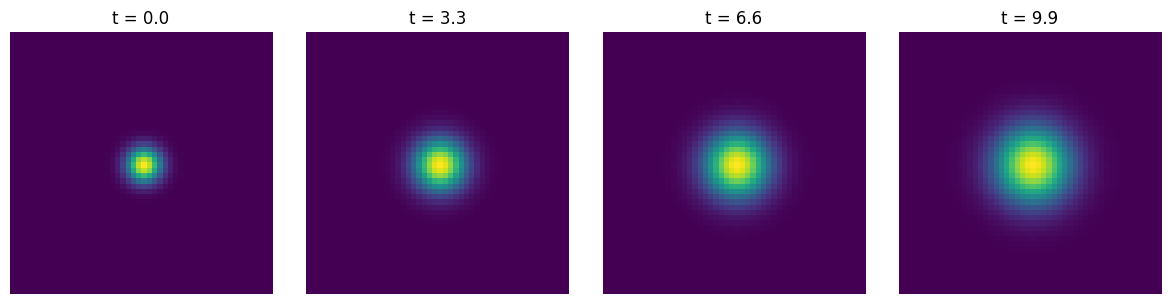

In [66]:
# Visualize a few snapshots
plt.figure(figsize=(12, 3))
for i, t_idx in enumerate([0, int(steps/3), int(2*steps/3), steps-1]):
    plt.subplot(1, 4, i+1)
    plt.imshow(u[t_idx], cmap='viridis')
    plt.title(f"t = {t_idx * dt:.1f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [67]:
print("u shape:", u.shape)

u shape: (100, 50, 50)


In [68]:
# Define Laplacian calculation
def compute_laplacian(u_frame, dx):
    lap = np.zeros_like(u_frame)
    lap[1:-1, 1:-1] = (
        u_frame[2:, 1:-1] + u_frame[:-2, 1:-1] +
        u_frame[1:-1, 2:] + u_frame[1:-1, :-2] -
        4 * u_frame[1:-1, 1:-1]
    ) / dx**2
    return lap

# Downsample space (central 10x10 region) and time (50 steps)
T_subset = 50
u_subset = u[:T_subset, 20:30, 20:30]  # central 10x10 block
laplacians = np.zeros_like(u_subset)

# Compute laplacians for each time step
for t in range(T_subset):
    laplacians[t] = compute_laplacian(u_subset[t], dx)

# Trim time series to compute finite difference (u_t)
X = np.stack([
    u_subset[:-1].reshape(T_subset-1, -1),               # u
    laplacians[:-1].reshape(T_subset-1, -1)              # laplacian(u)
], axis=-1)  # shape: (T_subset-1, n_points, 2)

X = X.reshape(-1, 2)  # collapse across time and space
X_dot = (u_subset[1:] - u_subset[:-1]).reshape(-1, 1) / dt  # u_t

In [69]:
# Configure and fit SINDy
optimizer = STLSQ(threshold=0.001, fit_intercept=False)
model = SINDy(
    optimizer=optimizer,
    feature_library=PolynomialLibrary(degree=1, include_interaction=False),
    feature_names=['u', 'laplacian']
)
model.fit(X, x_dot=X_dot)
model.print()

(u)' = 0.021 1 + -0.088 u + 0.778 laplacian
